### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import PIL
import pathlib
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

### Defining variables

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS=50
CHANNELS=3

### Importing Dataset 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

len(dataset)

Found 1846 files belonging to 9 classes.


58

In [4]:
class_names = dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Printing Images and respective Labels

In [5]:
for image_batch, label_batch in dataset.take(2):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(32, 256, 256, 3)
tf.Tensor(
[[[186.0567  130.26105 113.7702 ]
  [188.03717 132.06628 117.13422]
  [189.91296 139.0675  134.21265]
  ...
  [186.66016 140.53406 142.32037]
  [185.93964 140.9903  137.21686]
  [183.21997 138.34375 134.71027]]

 [[185.79144 133.2384  116.62158]
  [187.19495 131.30042 115.7038 ]
  [189.68976 135.04462 127.43732]
  ...
  [186.42865 142.34705 139.44366]
  [184.27344 139.71521 131.70416]
  [185.4433  136.33795 133.9259 ]]

 [[186.76843 133.8739  116.29578]
  [185.34766 132.06354 124.22162]
  [186.1004  127.38165 125.96527]
  ...
  [186.14337 139.17535 134.79456]
  [184.25287 136.22656 134.23395]
  [183.39899 134.3421  132.74438]]

 ...

 [[189.61108 148.67188 152.38843]
  [188.03125 152.06927 151.8789 ]
  [187.49725 146.82465 148.16248]
  ...
  [190.14337 152.17535 168.68677]
  [190.96875 154.92413 169.22162]
  [191.5597  151.74109 166.16235]]

 [[186.59576 149.83191 151.1579 ]
  [188.01776 149.5362  150.1211 ]
  [188.25061 148.21216 149.65009]
  ...
  [189.87

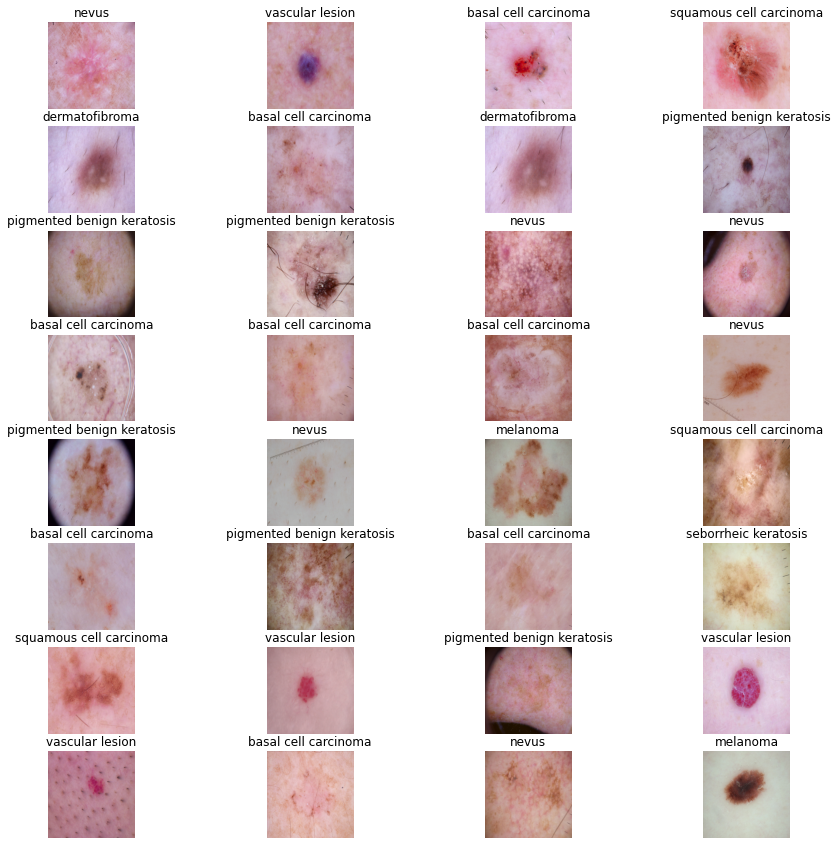

In [8]:
plt.figure(figsize=(15, 15))

for image_batch, labels_batch in dataset.take(1):
    
    for i in range(BATCH_SIZE):
        
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Create Function for Test, Train and Validation Split

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)                      # Train Split
    val_ds = ds.skip(train_size).take(val_size)         # Validation Split
    test_ds = ds.skip(train_size).skip(val_size)        # Test Split
    
    return train_ds, val_ds, test_ds

### Provide Partition to Dataset

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Autotuning of 3 datasets

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Resizing and Rescaling Layer

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation:


#### Creates Diff Image from a single image. It is helpful when there is less data available. Improves Accuracy

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Create Model with different Layers

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Model Compilation

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


### Checking Summary of the Model

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

### Model fitting 

In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
46/46 [==============================] - 105s 2s/step - loss: 2.0584 - accuracy: 0.2100 - val_loss: 2.0860 - val_accuracy: 0.2188
Epoch 2/50
46/46 [==============================] - 58s 1s/step - loss: 2.0147 - accuracy: 0.2271 - val_loss: 2.0713 - val_accuracy: 0.1813
Epoch 3/50
46/46 [==============================] - 46s 1s/step - loss: 2.0246 - accuracy: 0.2182 - val_loss: 2.0824 - val_accuracy: 0.2188
Epoch 4/50
46/46 [==============================] - 48s 1s/step - loss: 1.9890 - accuracy: 0.2654 - val_loss: 1.9630 - val_accuracy: 0.3500
Epoch 5/50
46/46 [==============================] - 46s 1s/step - loss: 1.8862 - accuracy: 0.3187 - val_loss: 1.7953 - val_accuracy: 0.3875
Epoch 6/50
46/46 [==============================] - 48s 1s/step - loss: 1.7272 - accuracy: 0.3912 - val_loss: 1.6831 - val_accuracy: 0.4125
Epoch 7/50
46/46 [==============================] - 48s 1s/step - loss: 1.6208 - accuracy: 0.4275 - val_loss: 1.6183 - val_accuracy: 0.3750
Epoch 8/50
46/46 [=

### Model Evaluation

In [20]:
model.evaluate(test_ds)

7/7 [==============================] - 13s 516ms/step - loss: 2.2015 - accuracy: 0.0848


[2.201474905014038, 0.0848214253783226]

### Checking Accuarcy and Losses 

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Ploting Accuarcy and Losses

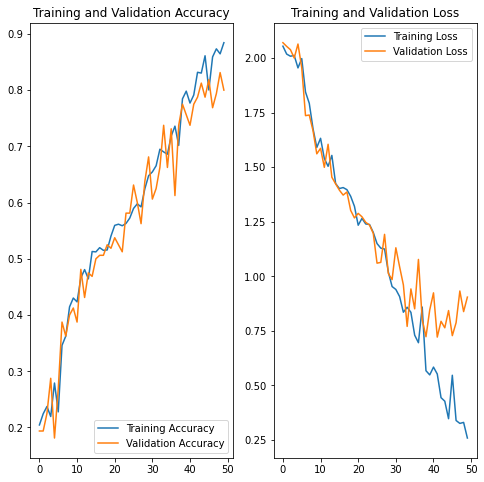

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicting model on random pre-labbled image 

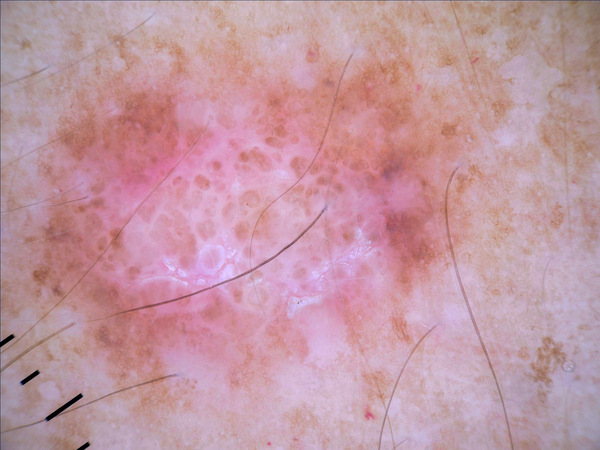

In [25]:
#For Predictions
image_path = "Data/Train/dermatofibroma/ISIC_0027626.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [26]:
pred = model.predict(scaled_img)

In [27]:
output = class_names[np.argmax(pred)]

In [28]:
output

'dermatofibroma'

### Saving Model

In [30]:
model.save("SkinCancer.h5")